#Twitter Popularity and Harassment

After the recent harassment of several prominent women in the gaming community (infamously known as #GamerGate) and Twitter's difficulty with dealing with said harassment issue, I wanted to try exploring if there was correlation between "Twitter popularity" and harassment.

The following metrics will be used for measuring a twitter user's "popularity": 
* Number of followers
* Number of tweets made
* Number of favourites per tweet
* List membership
* Friends count


"Harassment" will be measured by using sentiment analysis by traversing through said user's mentions and measuring the average polarity ranging from [-1.0,1.0] where more 'positive' tweets have higher polarities, while 'negative' tweets will have lower polarity. 

I also wanted to measure the polarity of said user's tweets against their mentions to see if there was a correlation (ie. if people that tweet more negatively have a higher chance of having more negative mentions, etc).

Afterwards, I want to predict the polarity (which I will use to define as "harassment") given a twitter user's "popularity." 


In [2]:
import twitter 
import json

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date
from matplotlib import pyplot as plt
from textblob import TextBlob
import requests
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster



In [3]:
CONSUMER_KEY = ''
with open('consumerkey.txt','r') as f:
    CONSUMER_KEY = f.readline().strip()
    
CONSUMER_SECRET =''
with open('consumersecret.txt','r') as f:
    CONSUMER_SECRET = f.readline().strip()

OAUTH_TOKEN = ''
with open('accesstoken.txt','r') as f:
    OAUTH_TOKEN = f.readline().strip()


OAUTH_TOKEN_SECRET = ''
with open('accesstokensecret.txt','r') as f:
    OAUTH_TOKEN_SECRET = f.readline().strip()

auth1 = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(auth=auth1)

#Testing if authorization worked
twitter_api

First, let's see how the textblob's sentiment analysis works. Below is an example of a positive sentence returning a relatively high polarity.

In [10]:

TextBlob('Happy great things in this example! Amazing! Wow! Incredible!').sentiment.polarity

0.7350000000000001

Below is an example of a negative setence returning a low polarity. 

In [11]:
TextBlob('Negative things in this example. Hate, awful, disgusting, worst').sentiment.polarity

-0.82

Now we can explore how TextBlob calculates the polarity of some tweets. Let's explore some of Kim Kardashian's tweets. 

In [21]:
#Grabs the 10 most recent tweet in Kim Kardashian's twitter
kims_tweets = twitter_api.statuses.user_timeline(user_id=25365536,count=10)

#Prints the first 10 tweets along with their calculated polarity 
for i in range(len(kims_tweets)):
    print kims_tweets[i]['text']
    print "Polarity:" , TextBlob(kims_tweets[i]['text']).sentiment.polarity
    print


Only 30 more minutes until a brand new #KUWTK, east coast!
Polarity: 0.223484848485

An all new #KUWTK airs tonight! Make sure to tune in XO
Polarity: 0.335227272727

Happy Easter everyone! Love this throwback of Kourtney, Khloe and Me with our daddy finishing an Easter egg hunt! http://t.co/PZnVWAFB1M
Polarity: 0.8125

Fam bam http://t.co/K8zZ7Xn4b9
Polarity: 0.0

I love my grandma!!!! http://t.co/pSTP1QJyxh
Polarity: 1.0

Easter prep! 🌷🐣🐰🍬 http://t.co/293oFlgGJg
Polarity: 0.0

@samsmithworld miss you too! xoxoxoxo
Polarity: 0.0

@KardashianNavy @samsmithworld IM NOT THE ONLY ONE!!!! But love the entire album
Polarity: 0.166666666667

Listening to @samsmithworld 😘
Polarity: 0.0

I JUST TOOK THIS QUIZ BC IM BORED &amp; GUESS WHO I AM. lol KIM!!! http://t.co/KSqQoPI6N9
Polarity: 0.25



From the above example, we see that tweets such as "I love my grandma!!!" have very high polarities and tweets such as "I JUST TOOK THIS QUIZ BC I'M BORED..." etc have relatively low polairities. Other tweets such as "Listening to @samsmithworld" and "Fam bam" parse as having neutral polarities as they have no relatively negativity or positivity. 

To use twitter's API, a twitter user's "ID" was required which is unique and unchangeable (unlike usernames, which are changeable)

* President Obama (@barackobama) ID: 813286
* Kim Kardashian (@kimkardashian) ID: 25365536
* Donald Trump (@realDonalTrump) ID: 25073877

First I explore tweets and mentions for the above users. 


In [195]:
#Gets the first 100 mentions for Obama, Kim, and Donald Trump
search_obama = twitter_api.search.tweets(q="@barackobama",count=100,lang='en')
search_kim = twitter_api.search.tweets(q="@kimkardashian",count=100,lang='en')
search_don = twitter_api.search.tweets(q="@realDonaldTrump",count=100,lang='en')

#Grabs the dictionary of mentions
obama = search_obama['statuses']
kim = search_kim['statuses']
don = search_don['statuses']

#For calculating polarity 
po = 0 
pk = 0
pd = 0

#Sums the total polarity score, to be averaged later
for i in range(len(obama)): 
    blob = TextBlob(obama[i]['text'])
    
    po+= TextBlob(obama[i]['text']).sentiment.polarity
    pk+= TextBlob(kim[i]['text']).sentiment.polarity
    pd+= TextBlob(don[i]['text']).sentiment.polarity
    
print "Average Polarity (Obama):", (po/len(obama))
print "Average Polarity (Kim Kardashian):", (pk/len(kim))
print "Average Polarity (Donald Trump):", (pd/len(don))


Average Polarity (Obama): 0.0368861860795
Average Polarity (Kim Kardashian): -0.00844186620671
Average Polarity (Donald Trump): -0.0756878382035


At the time that I ran this (since the mentions timeline changes over time), I had the following results:

* Average Polarity (Obama): 0.0368861860795
* Average Polarity (Kim Kardashian): -0.00844186620671
* Average Polarity (Donald Trump): -0.0756878382035

From here, we can see that Obama's mentions are generally more positive than that of Kim Kardashian's and Donald Trump's. It appears that Donald Trump has the most negative tweets in his mentions. 

Below I wrote a general function for finding the polarity of a user's mentions to be used when collecting data. 

In [18]:
#Function for calculating average polarity of mentions
def mentions_polarity(username):
    search_mentions = twitter_api.search.tweets(q="@"+username,count=100,lang='en')
    time.sleep(0.125)
    mentions = search_mentions['statuses']
    
    #If their mentions are empty return, None
    if len(mentions) == 0:
        return None
    
    p = 0
    
    for i in range(len(mentions)):
        blob = TextBlob(mentions[i]['text'])
        p+= TextBlob(mentions[i]['text']).sentiment.polarity
    
    return p/len(mentions)

In [131]:
mentions_polarity('barackobama')

0.09451093073593071

Next, I'm going to grab users from the following places:
* Users using the hashtag #GamerGate
* Users using the hashtag #StopGamerGate

And the following hashtag used as control: 
* Users using the #ThanksObama hashtag
    * I wanted to explore this tag since it's mostly used in a sarcastic way though it would be   interesting to explore in terms of polarity since sarcasm detection is still a problem that NLP doesn't have an elegant solution for.
    * Essentially, I wanted a middle ground between negative tweets and positive tweets.


Below are the functions I wrote to grab users using a certain hashtag then calculate their timeline polarity and mentions polarity 

I used the same method for data collection for the #EndGamerGate and #ThanksObama hashtags

In [14]:
#Method for collecting data for a given hashtag
def gather_data(hashtag):
    hashtag_search = twitter_api.search.tweets(q=hashtag,count=100,lang='en')
    time.sleep(0.125)
    
    #Initializes the dictionary 
    hashtag_dict = {} 
    
    #Grabs only the statuses
    hashtag_search = hashtag_search['statuses']
    
    for i in range(0,len(hashtag_search)):
        user = hashtag_search[i]['user']
        user_id = user['id']
        hashtag_dict[user_id] = {'followers_count': user['followers_count'],
                                   'friends_count': user['friends_count'], 'screen_name': user['screen_name'],
                                   'statuses_count': user['statuses_count'],'listed_count': user['listed_count'],
                                   'favourites_count': user['favourites_count']}
        u = user['screen_name']
        hashtag_dict[user_id]['mentions_polarity'] = mentions_polarity(u)
        hashtag_dict[user_id]['timeline_polarity'] = timeline_polarity(user_id)
        
        
        
    return hashtag_dict 


In [20]:
gather_data('#GamerGate')

{14052186: {'favourites_count': 459,
  'followers_count': 1034,
  'friends_count': 448,
  'listed_count': 78,
  'mentions_polarity': 0.33,
  'screen_name': u'courdek',
  'statuses_count': 10702,
  'timeline_polarity': 0.066484055016252},
 14792263: {'favourites_count': 82,
  'followers_count': 5172,
  'friends_count': 14,
  'listed_count': 360,
  'mentions_polarity': 0.07668194444444444,
  'screen_name': u'ScottGreenfield',
  'statuses_count': 43511,
  'timeline_polarity': 0.07663717532467532},
 17665210: {'favourites_count': 8042,
  'followers_count': 479,
  'friends_count': 480,
  'listed_count': 27,
  'mentions_polarity': 0.00195126262626263,
  'screen_name': u'Lugash',
  'statuses_count': 21216,
  'timeline_polarity': 0.062111789772727265},
 17956471: {'favourites_count': 21564,
  'followers_count': 1595,
  'friends_count': 1631,
  'listed_count': 29,
  'mentions_polarity': -0.016529662698412703,
  'screen_name': u'nomuru2d',
  'statuses_count': 30414,
  'timeline_polarity': 0.0361

Below is a function for calculating the average polarity of a user's tweets

In [19]:
#Calculates the polarity of a user's time line given their user id
def timeline_polarity(uid):
    
    #Grabs their first 100 tweets
    tweets = twitter_api.statuses.user_timeline(user_id=uid,count=100)
    time.sleep(0.5)
    
    #If their mentions is empty, return None
    if len(tweets) == 0:
        return None
    
    #For calculating polarity 
    p = 0
    
    for i in range(len(tweets)):
        p+= TextBlob(tweets[i]['text']).sentiment.polarity
        
        
    return p/len(tweets)

    

Below are the preliminary stats I calculated from the first batch of users I collected. Initially, I had the following results:

* GamerGate
    * Unique Users per 100 Tweets: 65
    * Average Mentions Polarity (100 tweets): 0.036349059358269556
    * Averate Timeline Polairty (100 tweets): 0.00549019303346
    
* StopGamerGate
    * Unique Users per 100 Tweets: 90
    * Average Mentions Polarity (100 tweets): 0.06762642536646489
    * Averate Timeline Polairty (100 tweets): 0.0365904498884

* ThanksObama
    * Unique Users per 100 Tweets: 58
    * Average Mentions Polarity (100 tweets): 0.07386042403986838
    * Averate Timeline Polairty (100 tweets): 0.053186128929

#####  **Note that the following cells cannot be run as I removed the  original dictionaries from this notebook and stored them in the python file combined.py**

In [12]:
gg_finaldf = pd.DataFrame(gg_final).transpose()
sgg_finaldf = pd.DataFrame(sgg_final).transpose()
thanks_finaldf = pd.DataFrame(thanks_final).transpose()


print "#GamerGate Average Timeline polarity: ", gg_finaldf['timeline_polarity'].mean()
print "#StopGamerGate Average Timeline polarity: ", sgg_finaldf['timeline_polarity'].mean()
print "#ThanksObama Average Timeline polarity: ", thanks_finaldf['timeline_polarity'].mean()
print

print "#GamerGate Average Followers: ", gg_finaldf['followers_count'].mean()
print "#StopGamerGate Average Followers: ", sgg_finaldf['followers_count'].mean()
print "#ThanksObama Average Followers: ", thanks_finaldf['followers_count'].mean()
print

print "#GamerGate Average Friends: ", gg_finaldf['friends_count'].mean()
print "#StopGamerGate Average Friends: ", sgg_finaldf['friends_count'].mean()
print "#ThanksObama Average Friends: ", thanks_finaldf['friends_count'].mean()
print

print "#GamerGate Average Tweets: ", gg_finaldf['statuses_count'].mean()
print "#StopGamerGate Average Tweets: ", sgg_finaldf['statuses_count'].mean()
print "#ThanksObama Average Tweets: ", thanks_finaldf['statuses_count'].mean()


#GamerGate Average Timeline polarity:  0.00549019303346
#StopGamerGate Average Timeline polarity:  0.0365904498884
#ThanksObama Average Timeline polarity:  0.053186128929

#GamerGate Average Followers:  733.738461538
#StopGamerGate Average Followers:  1089.67777778
#ThanksObama Average Followers:  23533.3448276

#GamerGate Average Friends:  834.584615385
#StopGamerGate Average Friends:  725.044444444
#ThanksObama Average Friends:  7908.60344828

#GamerGate Average Tweets:  16625.6153846
#StopGamerGate Average Tweets:  24640.8333333
#ThanksObama Average Tweets:  31758.637931


Below I calculate correlation coefficients

In [166]:
#Converts data from type "objects" to floats and ints
gg_finaldf = gg_finaldf.convert_objects(convert_numeric=True)
sgg_finaldf = sgg_finaldf.convert_objects(convert_numeric=True)
thanks_finaldf = thanks_finaldf.convert_objects(convert_numeric=True)

#Calculates correlation coefficients

print "Followers Count vs. Mentions Polarity"
print "#GamerGate:", gg_finaldf['followers_count'].corr(gg_finaldf['mentions_polarity'])
print "#StopGamerGate:", sgg_finaldf['followers_count'].corr(sgg_finaldf['mentions_polarity'])
print "#ThanksObama:", thanks_finaldf['followers_count'].corr(thanks_finaldf['mentions_polarity'])
print

print "Follower Count vs. Friends Count"
print "#GamerGate:", gg_finaldf['followers_count'].corr(gg_finaldf['friends_count'])
print "#StopGamerGate:", sgg_finaldf['followers_count'].corr(sgg_finaldf['friends_count'])
print "#ThanksObama:",thanks_finaldf['followers_count'].corr(thanks_finaldf['friends_count'])
print


print "Mentions Polarity vs. Timeline Polarity"
print "#GamerGate:", gg_finaldf['timeline_polarity'].corr(gg_finaldf['mentions_polarity'])
print "#StopGamerGate:", sgg_finaldf['timeline_polarity'].corr(sgg_finaldf['mentions_polarity'])
print "#ThanksObama:", thanks_finaldf['timeline_polarity'].corr(thanks_finaldf['mentions_polarity'])
print


print "Mentions Polarity vs. Status Count"
print "#GamerGate:", gg_finaldf['statuses_count'].corr(gg_finaldf['mentions_polarity'])
print "#StopGamerGate:", sgg_finaldf['statuses_count'].corr(sgg_finaldf['mentions_polarity'])
print "#ThanksObama:", thanks_finaldf['statuses_count'].corr(thanks_finaldf['mentions_polarity'])
print


Followers Count vs. Mentions Polarity
#GamerGate: -0.0022757414855
#StopGamerGate: -0.0159337434801
#ThanksObama: -0.0361130635362

Follower Count vs. Friends Count
#GamerGate: 0.743649087383
#StopGamerGate: 0.292269495898
#ThanksObama: 0.960241023843

Mentions Polarity vs. Timeline Polarity
#GamerGate: -0.0802402473903
#StopGamerGate: 0.293868892763
#ThanksObama: 0.335783133598

Mentions Polarity vs. Status Count
#GamerGate: 0.0452157667676
#StopGamerGate: 0.325802114866
#ThanksObama: 0.0974486694264



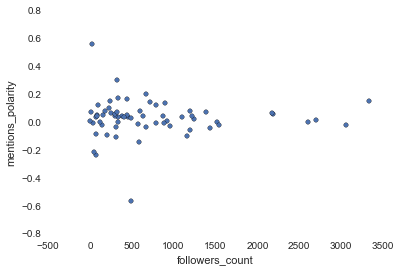

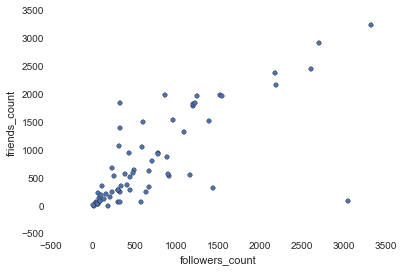

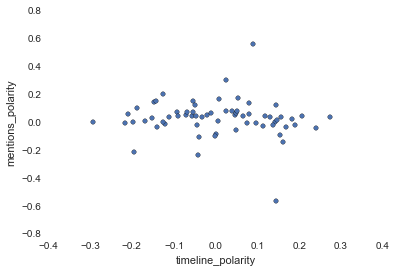

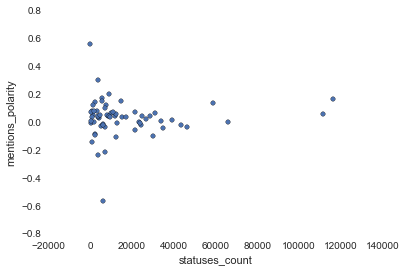

In [176]:
gg_finaldf.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
gg_finaldf.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
gg_finaldf.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
gg_finaldf.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')

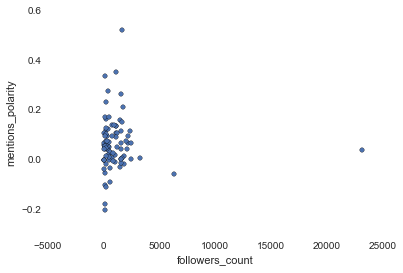

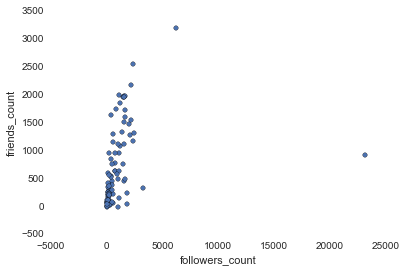

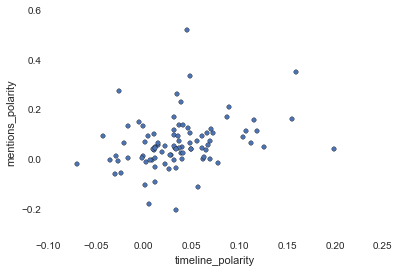

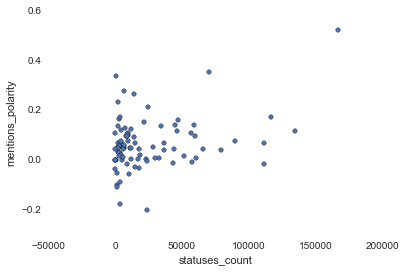

In [177]:
sgg_finaldf.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
sgg_finaldf.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
sgg_finaldf.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
sgg_finaldf.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')

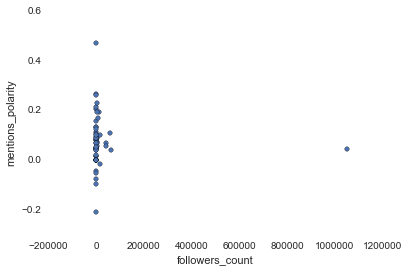

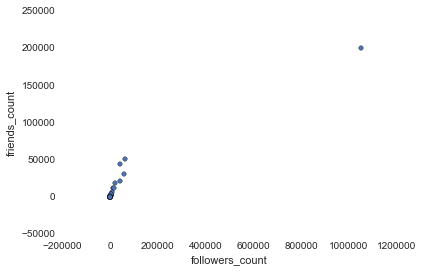

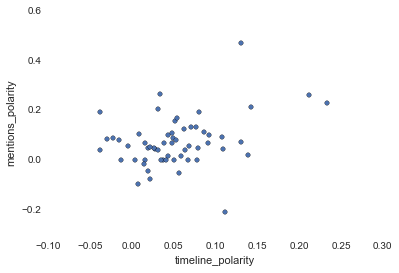

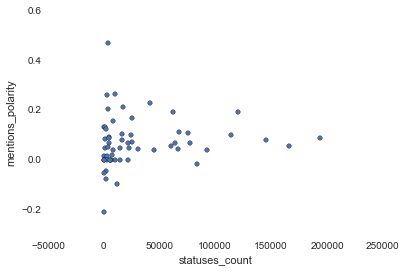

In [178]:
thanks_finaldf.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
thanks_finaldf.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
thanks_finaldf.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
thanks_finaldf.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')

Afterwards, I collected data by running "collect_data" several times for each of the hashtags until I had ~200 users per hashtag. While I was collecting data, I noticed that the #GamerGate and #StopGamerGate hashtags had less unique users than #ThanksObama after each run - this is most likely due to each respective "movement" having the same users post to the tag frequently while #ThanksObama is used more often in general in a sarcatic or joking manner.

Unrelated but somewhat interesting - since I did each run at random times over 3 days, I noticed a sudden large increase in users for #ThanksObama around April 16th and April 17th. I was curious so I decided to go on hashtag and found that a lot of people were using #ThanksObama with regards to the recent release of the new Star Wars Trailer. 

Below, I stored the total collected data in a python file called "combined" that contains all the final dictionaries and imported it. 

In [10]:
import combined
reload(combined)

<module 'combined' from 'combined.pyc'>

In [11]:
print "Number of Users Collected"
print "#GamerGate:",len(combined.gg_all)
print "#StopGamerGate:",len(combined.sgg_all)
print "#ThanksObama:",len(combined.thanks_all)

Number of Users Collected
#GamerGate: 199
#StopGamerGate: 197
#ThanksObama: 246


In [12]:
#Combining all the data into one large dictionary for later use
all_users = {}
all_users.update(combined.gg_all)
all_users.update(combined.sgg_all)
all_users.update(combined.thanks_all)
print "Total Users Collected:", len(all_users)

#Converts all_users dictionary to a data frame for later use
all_combine = pd.DataFrame(all_users).transpose()


Total Users Collected: 615


With the new collected data, I performed the same preliminary stats as I did with the individual smaller data sets. 

In [13]:
gg_combine = pd.DataFrame(combined.gg_all).transpose()
sgg_combine = pd.DataFrame(combined.sgg_all).transpose()
thanks_combine = pd.DataFrame(combined.thanks_all).transpose()


print "#GamerGate Average Timeline polarity: ", gg_combine['timeline_polarity'].mean()
print "#StopGamerGate Average Timeline polarity: ", sgg_combine['timeline_polarity'].mean()
print "#ThanksObama Average Timeline polarity: ", thanks_combine['timeline_polarity'].mean()
print


print "#GamerGate Average Mentions polarity: ", gg_combine['mentions_polarity'].mean()
print "#StopGamerGate Average Mentions polarity: ", sgg_combine['mentions_polarity'].mean()
print "#ThanksObama Average Mentions polarity: ", thanks_combine['mentions_polarity'].mean()
print


print "#GamerGate Average Followers: ", gg_combine['followers_count'].mean()
print "#StopGamerGate Average Followers: ", sgg_combine['followers_count'].mean()
print "#ThanksObama Average Followers: ", thanks_combine['followers_count'].mean()
print

print "#GamerGate Average Friends: ", gg_combine['friends_count'].mean()
print "#StopGamerGate Average Friends: ", sgg_combine['friends_count'].mean()
print "#ThanksObama Average Friends: ", thanks_combine['friends_count'].mean()
print

print "#GamerGate Average Tweets: ", gg_combine['statuses_count'].mean()
print "#StopGamerGate Average Tweets: ", sgg_combine['statuses_count'].mean()
print "#ThanksObama Average Tweets: ", thanks_combine['statuses_count'].mean()


#GamerGate Average Timeline polarity:  0.0315156112402
#StopGamerGate Average Timeline polarity:  0.0392955921602
#ThanksObama Average Timeline polarity:  0.0736554837942

#GamerGate Average Mentions polarity:  0.0441494400419
#StopGamerGate Average Mentions polarity:  0.062978498202
#ThanksObama Average Mentions polarity:  0.102303311349

#GamerGate Average Followers:  893.467336683
#StopGamerGate Average Followers:  1029.5786802
#ThanksObama Average Followers:  6488.54878049

#GamerGate Average Friends:  884.190954774
#StopGamerGate Average Friends:  799.329949239
#ThanksObama Average Friends:  2604.74796748

#GamerGate Average Tweets:  17710.1557789
#StopGamerGate Average Tweets:  24022.2030457
#ThanksObama Average Tweets:  23089.5853659


After collecting about 200 users per hashtag, the results for average timeline polarity, mentions polarity, followers, friends, and tweets still stay relatively the same. 

Below, I calculate the correlation coefficients for each of the separate dataframes (incuding the combined dataframe) for each hashtag.

In [14]:
#Converts all the data types for each dataframe from objects to be numeric values, when possible
gg_combine = gg_combine.convert_objects(convert_numeric=True)
sgg_combine = sgg_combine.convert_objects(convert_numeric=True)
thanks_combine = thanks_combine.convert_objects(convert_numeric=True)
all_combine = all_combine.convert_objects(convert_numeric=True)

In [15]:
print "#GamerGate Correlation Coefficients"
print "Followers vs. Mentions Polarity: ",gg_combine['followers_count'].corr(gg_combine['mentions_polarity'])
print "Followers vs. Friends: ", gg_combine['followers_count'].corr(gg_combine['friends_count'])
print "Mentions Polarity vs. Timeline Polarity: ", gg_combine['timeline_polarity'].corr(gg_combine['mentions_polarity'])
print "Mentions Polarity vs. Status Count: ", gg_combine['mentions_polarity'].corr(gg_combine['statuses_count'])
print "Mentions Polarity vs. Friends: ", gg_combine['friends_count'].corr(gg_combine['mentions_polarity'])
print 


print "#StopGamerGate Correlation Coefficients"
print "Followers vs. Mentions Polarity: ",sgg_combine['followers_count'].corr(sgg_combine['mentions_polarity'])
print "Followers vs. Friends: ", sgg_combine['followers_count'].corr(gg_combine['friends_count'])
print "Mentions Polarity vs. Timeline Polarity: ", sgg_combine['timeline_polarity'].corr(sgg_combine['mentions_polarity'])
print "Mentions Polarity vs. Status Count: ", sgg_combine['mentions_polarity'].corr(sgg_combine['statuses_count'])
print "Mentions Polarity vs. Friends: ", sgg_combine['friends_count'].corr(sgg_combine['mentions_polarity'])
print 

print "#ThanksObama Correlation Coefficients"
print "Followers vs. Mentions Polarity: ",thanks_combine['followers_count'].corr(thanks_combine['mentions_polarity'])
print "Followers vs. Friends: ", thanks_combine['followers_count'].corr(thanks_combine['friends_count'])
print "Mentions Polarity vs. Timeline Polarity: ", thanks_combine['timeline_polarity'].corr(thanks_combine['mentions_polarity'])
print "Mentions Polarity vs. Status Count: ", thanks_combine['mentions_polarity'].corr(thanks_combine['statuses_count'])
print "Mentions Polarity vs. Friends: ", thanks_combine['friends_count'].corr(thanks_combine['mentions_polarity'])
print 

print "Combined Correlation Coefficients"
print "Followers vs. Mentions Polarity: ",all_combine['followers_count'].corr(all_combine['mentions_polarity'])
print "Followers vs. Friends: ", all_combine['followers_count'].corr(all_combine['friends_count'])
print "Mentions Polarity vs. Timeline Polarity: ", all_combine['timeline_polarity'].corr(all_combine['mentions_polarity'])
print "Mentions Polarity vs. Status Count: ", all_combine['mentions_polarity'].corr(all_combine['statuses_count'])
print "Mentions Polarity vs. Friends: ", all_combine['friends_count'].corr(all_combine['mentions_polarity'])
print 


#GamerGate Correlation Coefficients
Followers vs. Mentions Polarity:  -0.0375911568119
Followers vs. Friends:  0.830613578882
Mentions Polarity vs. Timeline Polarity:  -0.0554511228202
Mentions Polarity vs. Status Count:  0.0568853100355
Mentions Polarity vs. Friends:  -0.0207649047999

#StopGamerGate Correlation Coefficients
Followers vs. Mentions Polarity:  0.0296543866388
Followers vs. Friends:  0.639196673987
Mentions Polarity vs. Timeline Polarity:  0.278311522481
Mentions Polarity vs. Status Count:  0.17097135397
Mentions Polarity vs. Friends:  0.0191895504307

#ThanksObama Correlation Coefficients
Followers vs. Mentions Polarity:  -0.0255483125423
Followers vs. Friends:  0.937581685976
Mentions Polarity vs. Timeline Polarity:  0.260303216544
Mentions Polarity vs. Status Count:  0.000887909691385
Mentions Polarity vs. Friends:  -0.0172351834853

Combined Correlation Coefficients
Followers vs. Mentions Polarity:  -0.00413365785776
Followers vs. Friends:  0.935204070239
Mentions Po

Below, I plot scatter plots for each dataframe to get a visual on how the data looks before attempting linear regression or logistic regression. 

#GamerGate Plots


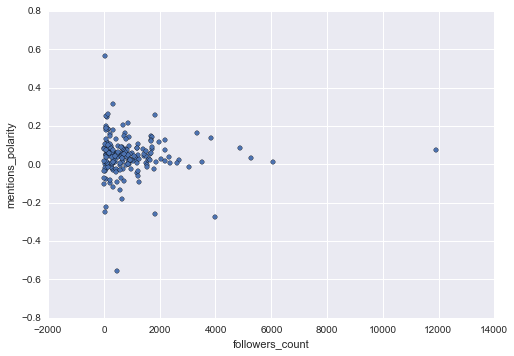

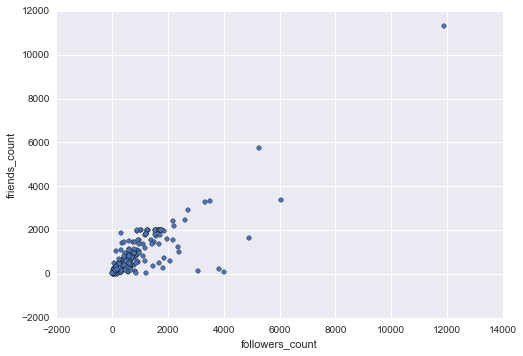

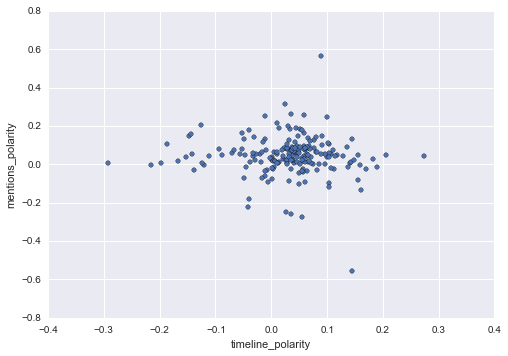

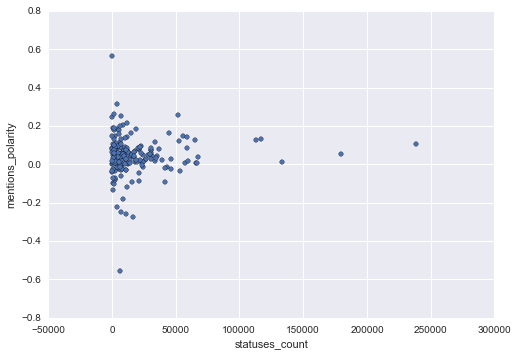

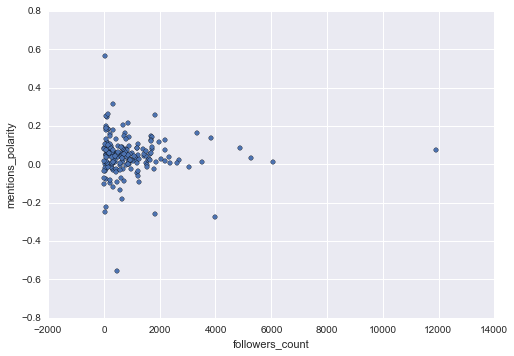

In [16]:
gg_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
gg_combine.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
gg_combine.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
gg_combine.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')
gg_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')

print "#GamerGate Plots"

#StopGamerGate Plots


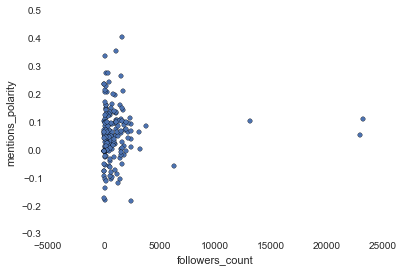

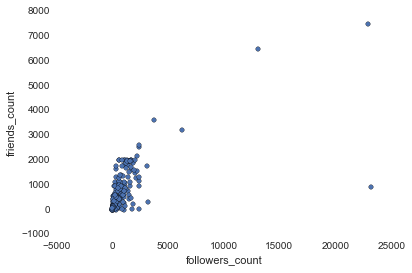

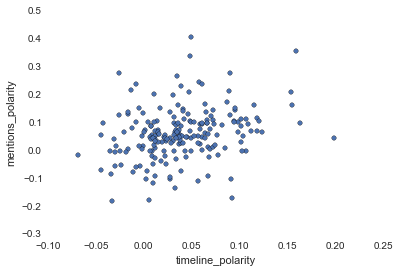

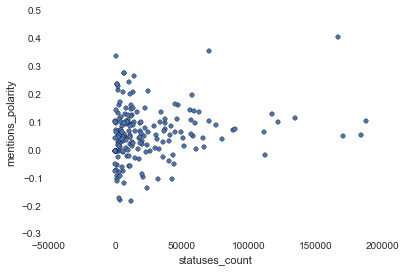

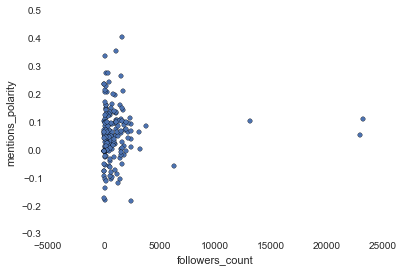

In [136]:
sgg_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
sgg_combine.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
sgg_combine.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
sgg_combine.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')
sgg_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')

print "#StopGamerGate Plots"

#ThanksObama Plots


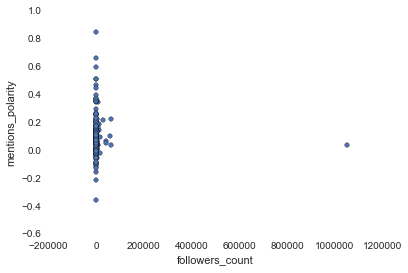

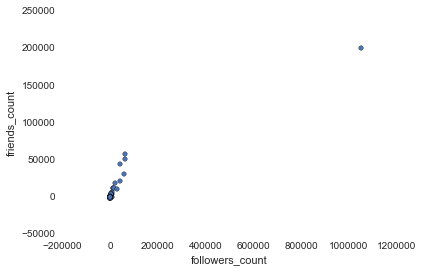

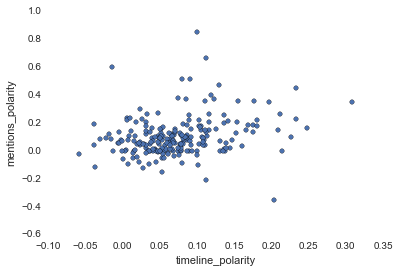

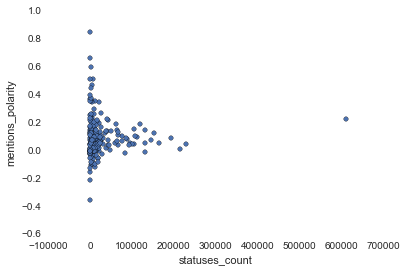

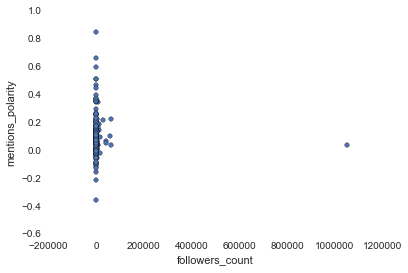

In [137]:
thanks_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
thanks_combine.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
thanks_combine.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
thanks_combine.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')
thanks_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')

print "#ThanksObama Plots"

Combined Data Frame


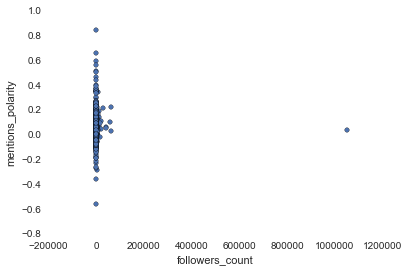

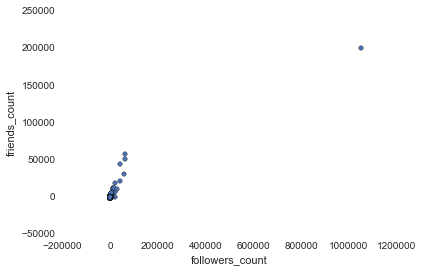

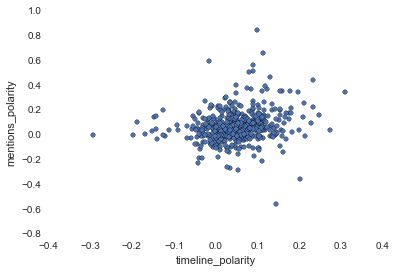

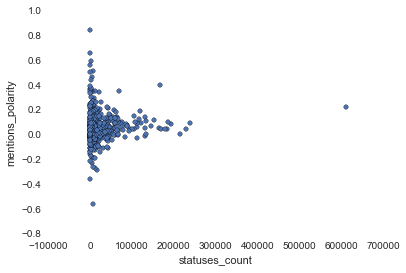

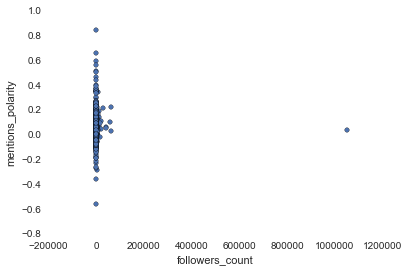

In [134]:
all_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
all_combine.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
all_combine.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
all_combine.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')
all_combine.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')

print "Combined Data Plots"

I noticed that for each dataset, there was a user with an unsually high amount of followers,friends, and statuses that might have skewed the data so I decided to take a look. 

In [15]:
print "Maximum Values for Combined Datafame"
print all_combine.max()
print

print "User ID with Most Friends:", all_combine['friends_count'].argmax()
print "User ID with Most Followers:", all_combine['followers_count'].argmax()
print "User ID with Most Statuses:", all_combine['statuses_count'].argmax()


Maximum Values for Combined Datafame
favourites_count        299370
followers_count        1049001
friends_count           201320
listed_count               775
mentions_polarity    0.8541667
screen_name             zedoom
statuses_count          610716
timeline_polarity    0.3084649
dtype: object

User ID with Most Friends: 242618658
User ID with Most Followers: 242618658
User ID with Most Statuses: 91734908


After looking the profiles of the users with the corresponding, I found that the users with the unusually high stats were @AppSame, whose bio says "A Conservative Political Marketing Firm helping to bring America back to its greatness" and the user with the most statuses was a user under the name @Tigerfists88, whose bio claims that he "autofollows", hence the large number of statuses. Both users came from the original #ThanksObama users dataframe. 

I decided to drop both users from the combined dataframe for better results.


Comibined Data Plots (Outliers Removed)


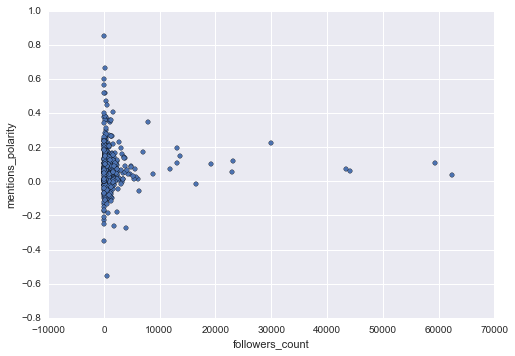

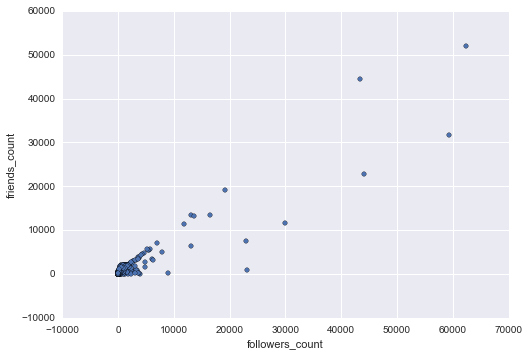

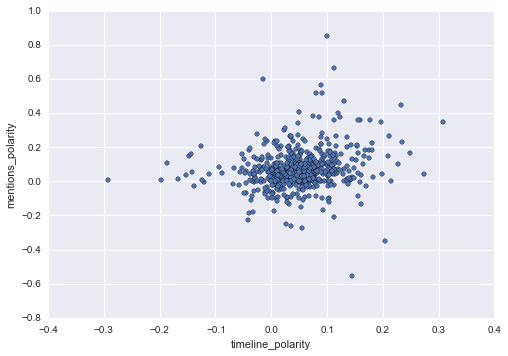

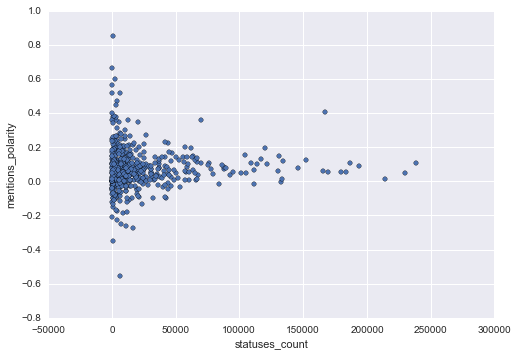

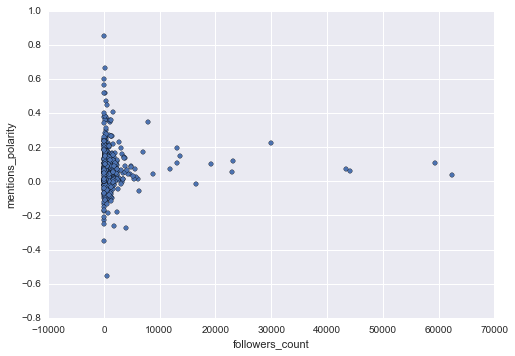

In [17]:
#Drops said users from dataframe
all_combine1 = all_combine.drop([242618658])
all_combine1 = all_combine1.drop([91734908])

#Plots the data without the outliers
all_combine1.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')
all_combine1.plot(kind='scatter', x= 'followers_count', y= 'friends_count')
all_combine1.plot(kind='scatter', x= 'timeline_polarity', y= 'mentions_polarity')
all_combine1.plot(kind='scatter', x= 'statuses_count', y= 'mentions_polarity')
all_combine1.plot(kind='scatter', x= 'followers_count', y= 'mentions_polarity')

print "Comibined Data Plots (Outliers Removed)"


In [17]:
print "Combined Correlation Coefficients"
print "Followers vs. Mentions Polarity: ",all_combine1['followers_count'].corr(all_combine1['mentions_polarity'])
print "Followers vs. Friends: ", all_combine1['followers_count'].corr(all_combine1['friends_count'])
print "Mentions Polarity vs. Timeline Polarity: ", all_combine1['timeline_polarity'].corr(all_combine1['mentions_polarity'])
print "Mentions Polarity vs. Status Count: ", all_combine1['mentions_polarity'].corr(all_combine1['statuses_count'])
print "Mentions Polarity vs. Friends: ", all_combine1['followers_count'].corr(all_combine1['mentions_polarity'])
print 

Combined Correlation Coefficients
Followers vs. Mentions Polarity:  0.014950924716
Followers vs. Friends:  0.922953714001
Mentions Polarity vs. Timeline Polarity:  0.196001691357
Mentions Polarity vs. Status Count:  0.0280452388919
Mentions Polarity vs. Friends:  0.014950924716



### Linear Regression Model 

Next, I attempt to find a line of best fit for the combined dataframe using linear regression after normalizing the data.

Initially, I had dropped the NaN values since having a polarity of 0.0 (neutral sentiment) was different from having no mentions at all so filling them would 0.0 would not be the same. However, I decided that it was inconsequential to fill them with 0.0 since in reality, having no mentions is essentially the same as having neutral mentions polarity. 

In [85]:
#Makes a copy of the original dataframe
all_combine2 = all_combine1.copy()

#Drops the "screen_name" column
all_combine2 = all_combine2.drop('screen_name',axis=1)

#Fills all NaN values with 0 
all_combine2 = all_combine2.fillna(0)

#Normalizes the data
dfNormal = StandardScaler().fit_transform(all_combine2)

In [47]:
#Reconstructs a dataframe from the normalized data
oldcols = all_combine2.columns

dfNormal = pd.DataFrame(dfNormal)
dfNormal.columns = oldcols


In [48]:
#Sets y to be mentions polarity
y = dfNormal.mentions_polarity

#Drops mentions polarity from the dataframe
dfNormal = dfNormal.drop(['mentions_polarity'], axis=1)

#Sets x to be the rest of the features
X = dfNormal

#Saves columns from new dataframe for later use
coll = dfNormal.columns

In [49]:
#Shuffles the data
X, y = utils.shuffle(X, y, random_state=1)

Tests and Training the Data

(367, 6) (367,)
(246, 6) (246,)


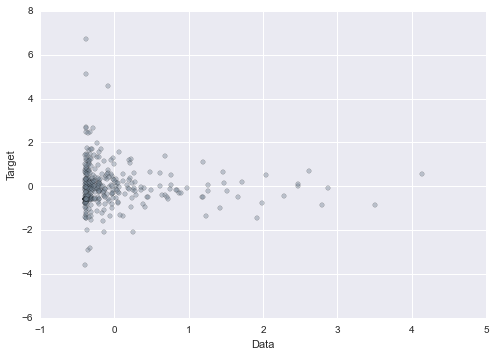

In [50]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

subX_train = X_train[:,0]
subX_test = X_test[:,0]
plt.scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
# plt.scatter(subX_test, y_test, c="seagreen", alpha=0.2, linewidths=0.3)
plt.xlabel('Data')
plt.ylabel('Target');

Displays the scatter plots of the normalized data and features to get a visual on how they relate to mentions polarity

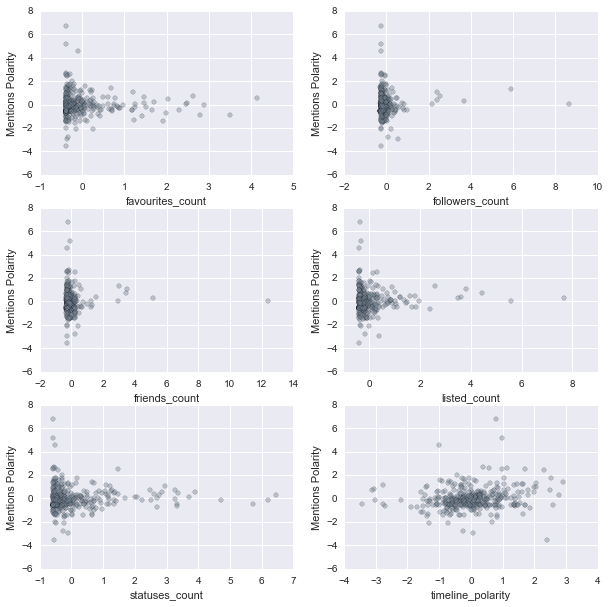

In [34]:
fig, axes = plt.subplots(3,2,figsize=(10,10))

for i in range(6):
    plt_i = i // 2
    plt_j = i % 2
    subX_train = X_train[:,i]
    # plt.subplot(2, 4, 1 + i)
    axes[plt_i][plt_j].scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
    #plt.scatter(subX_test, y_test)
    axes[plt_i][plt_j].set_xlabel(coll[i])
    axes[plt_i][plt_j].set_ylabel('Mentions Polarity'); 

In [35]:
#Creates a new linear regression object
regr = linear_model.LinearRegression(normalize=True)

In [36]:
#Fits the data
print X_train.shape
regr.fit(X_train, y_train);

(367, 6)


In [37]:
#Training and test error
print("Training error: ", metrics.mean_squared_error(regr.predict(X_train),y_train))
print("Test     error: ", metrics.mean_squared_error(regr.predict(X_test),y_test))

('Training error: ', 0.90157151628658083)
('Test     error: ', 1.0993926841247108)


In [38]:
#Training and test score
train_score = regr.score(X_train,y_train)
test_score = regr.score(X_test,y_test)
print("Training score: ", train_score)
print("Test     score: ", test_score)

('Training score: ', 0.028229964853775047)
('Test     score: ', 0.007058446443589661)


In [39]:
#Finds coefficients and intercept
coefficients = regr.coef_

for i in range(len(coefficients)):
    print coll[i],"\t",coefficients[i]
intercept = regr.intercept_

print intercept

favourites_count 	-0.078385853325
followers_count 	0.0550715899475
friends_count 	-0.03787242195
listed_count 	0.0293821048335
statuses_count 	0.0206745476443
timeline_polarity 	0.150661091098
-0.0173318775228


In [40]:
print pd.DataFrame(zip(coll, np.transpose(coefficients)))

                   0         1
0   favourites_count -0.078386
1    followers_count  0.055072
2      friends_count -0.037872
3       listed_count  0.029382
4     statuses_count  0.020675
5  timeline_polarity  0.150661


In [41]:
#Cross validation scores
regr = linear_model.LinearRegression()
scores = cross_validation.cross_val_score(regr, X, y, cv=5)
print scores

[ 0.04740633  0.03166909 -0.04166549  0.05643821  0.03033949]


In [42]:
#Regression score
print("Regression score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Regression score: 0.02 (+/- 0.07)


Below the data is graphed as one plot with the regression line as a test

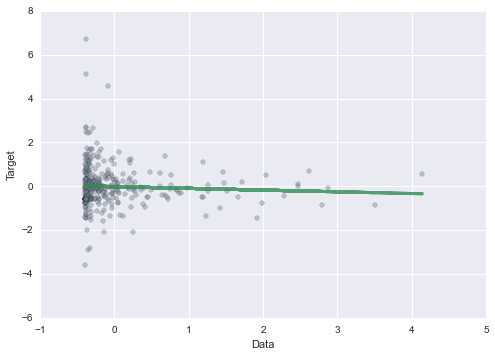

In [43]:
subX_train = X_train[:,0]
subX_test = X_test[:,0]
plt.scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
plt.plot(subX_train, ((coefficients[0]*subX_train)+intercept), color='seagreen', linewidth=3, alpha=.8);
plt.xlabel('Data')
plt.ylabel('Target');

Below are the graphs of the features and the fitted linear regression line

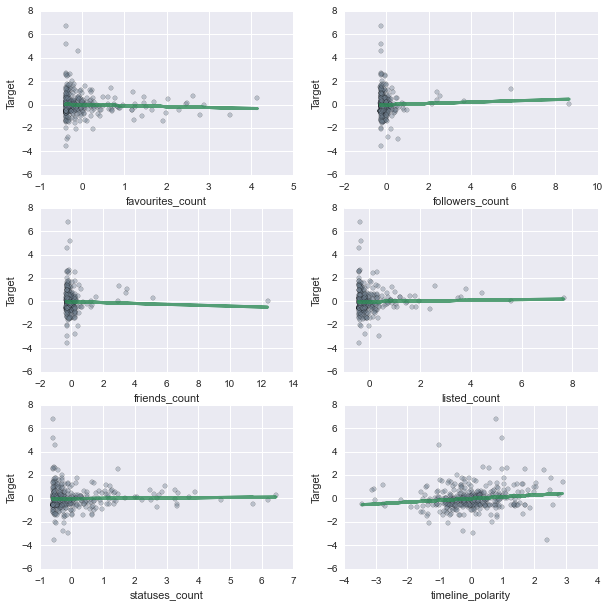

In [44]:
fig2, axes2 = plt.subplots(3,2,figsize=(10,10))

for i in range(6):
    plt_i = i // 2
    plt_j = i % 2
    subX_train = X_train[:,i]
    axes2[plt_i][plt_j].scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
    axes2[plt_i][plt_j].plot(subX_train, ((coefficients[i]*subX_train)+intercept), color='seagreen', linewidth=3, alpha=.8);
    axes2[plt_i][plt_j].set_xlabel(coll[i])
    axes2[plt_i][plt_j].set_ylabel('Mentions Polarity');

As it appears, there doesn't seem to be a strong correlation between the features and mentions polarity. Initially, I hypothesized that there would be a strong relation between these features and negative mentions polarity. 

Of all the features, it appears that 'timeline_polarity' had the strongest (positive) correaltion. Generally, the more "positive" a users' timeline is, the more likely they are to have more positive and "nicer" tweets in their mentions while the opposite is also true (more negative time line would result in more negative mentions, etc) 

### Logistic Regression and Predictions

Below, I build a logistic regression model in an attempt to predict mentions polarity besed on the aforementioned features. 

In [86]:
#Before determining how I define "positive" tweets I look at the averages for mentions and
#followers polarity

print "Average Mentions Polarity:", all_combine2['mentions_polarity'].mean()
print "Average Timeline Polarity:", all_combine2['timeline_polarity'].mean()


Average Mentions Polarity: 0.067051695428
Average Timeline Polarity: 0.050354875455


I define "positive" tweets as anything above 0.05 and "negative" tweets anything below that. 

In [87]:
#Makes a copy of the original dataframe
all_combine3 = all_combine2.copy()

#Define "negative mentions" as anything below with 0.05 polarity 
all_combine3['negative_mentions'] = (all_combine3.mentions_polarity < 0.05).astype(int)

all_combine3

,favourites_count,followers_count,friends_count,listed_count,mentions_polarity,statuses_count,timeline_polarity,negative_mentions
20383,3068,400,679,17,0.056260,5325,0.107474,0
557563,70737,1071,997,74,0.077548,37117,0.058723,0
684743,4138,3738,3628,398,0.088005,42000,0.101288,0
1394361,3172,1536,1961,120,0.116536,46489,0.106894,0
1484341,3321,1033,1827,53,0.099180,37107,0.066226,0
5054001,398,3368,619,155,0.013869,18431,0.136552,1
8057892,1067,395,851,14,0.045203,18018,0.198918,1
11353012,28307,11903,11302,176,0.074496,31057,0.060580,0
12884962,6492,1085,961,86,0.111756,56805,0.072328,0
13796782,150,1450,774,75,0.164729,47191,0.114913,0


Prepares data for logistic regression for predictions, where newY is the precense of negative mentions and newX are all the features. 

In [88]:
newY = all_combine3.negative_mentions

#Drops the negative_mentions column and mentions_polarity column
all_combine3 = all_combine3.drop(['negative_mentions'], axis=1)
all_combine3 = all_combine3.drop(['mentions_polarity'], axis=1)
newX = all_combine3

Training and Testing the data: 

In [89]:
X2_train, X2_test, y2_train, y2_test = cross_validation.train_test_split(newX,
                                                                     newY,
                                                                     test_size=0.8,
                                                                     random_state=0
                                                                     )
logistic_regr = linear_model.LogisticRegression()
logistic_regr.fit(X2_train, y2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

Predictions

In [90]:
y2_predicted = logistic_regr.predict(X2_test)
print y2_predicted

[1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 1]


Probabilities of Having Negative Mentions

In [91]:
probs2 = logistic_regr.predict_proba(X2_test)
print probs2

[[  4.44483913e-01   5.55516087e-01]
 [  7.51165556e-01   2.48834444e-01]
 [  5.25205049e-01   4.74794951e-01]
 [  2.57688842e-01   7.42311158e-01]
 [  4.53990293e-01   5.46009707e-01]
 [  4.83022789e-01   5.16977211e-01]
 [  4.77770605e-01   5.22229395e-01]
 [  4.36336146e-01   5.63663854e-01]
 [  4.69759297e-01   5.30240703e-01]
 [  4.20105494e-01   5.79894506e-01]
 [  4.89371108e-01   5.10628892e-01]
 [  3.55176832e-01   6.44823168e-01]
 [  4.57205937e-01   5.42794063e-01]
 [  4.55731523e-01   5.44268477e-01]
 [  4.80537037e-01   5.19462963e-01]
 [  4.64147168e-01   5.35852832e-01]
 [  5.45994269e-01   4.54005731e-01]
 [  4.69263173e-01   5.30736827e-01]
 [  4.83090883e-01   5.16909117e-01]
 [  6.63139805e-01   3.36860195e-01]
 [  5.95000500e-01   4.04999500e-01]
 [  4.63194467e-01   5.36805533e-01]
 [  4.52597032e-01   5.47402968e-01]
 [  3.18037238e-01   6.81962762e-01]
 [  4.81510277e-01   5.18489723e-01]
 [  4.80706927e-01   5.19293073e-01]
 [  5.29905668e-01   4.70094332e-01]
 

* Accuracy of the predicted model
    * As expected, predicting harassment given the collected features is not a good predictor and is only about 50% accurate. 

In [92]:
print metrics.accuracy_score(y2_test, y2_predicted)

0.505091649695


Printing the Report

In [93]:
print metrics.confusion_matrix(y2_test, y2_predicted)
print metrics.classification_report(y2_test, y2_predicted)

[[ 58 210]
 [ 33 190]]
             precision    recall  f1-score   support

          0       0.64      0.22      0.32       268
          1       0.47      0.85      0.61       223

avg / total       0.56      0.51      0.45       491



Examining Coefficients

In [94]:
print pd.DataFrame(zip(newX.columns, np.transpose(logistic_regr.coef_)))

                   0                     1
0   favourites_count  [-4.36985482174e-06]
1    followers_count   [0.000345204391051]
2      friends_count   [0.000268634111991]
3       listed_count    [-0.0208420665337]
4     statuses_count   [5.22732349157e-06]
5  timeline_polarity   [-0.00999609376981]


Evaluate the Score Model

In [95]:
scores = cross_validation.cross_val_score(linear_model.LogisticRegression(),
                                          newX,
                                          newY,
                                          scoring='accuracy',
                                          cv=10)
print scores
print scores.mean()

[ 0.61290323  0.58064516  0.5         0.6557377   0.54098361  0.55737705
  0.50819672  0.52459016  0.60655738  0.60655738]
0.56935483871


Below I make predictions based on the following users stats

* User 1
    * Status Count: 67,000
    * Following: 1,000
    * Listed: 5
    * Friends: 700
    * Favourite Count: 28,000
    * Timeline Polarity: 0.06
    
* User 2
    * Status Count: 21,600
    * Following: 302
    * Listed: 0
    * Friends: 135
    * Favourite Count: 8383
    * Timeline Polarity: 0.05

In [96]:
#Predictions for User 1
logistic_regr.predict_proba(np.array([28000,1000,700,5,67000,0.06]))

array([[ 0.32758076,  0.67241924]])

User 1 - The probability of having negative mentions is ~67%, which is interesting given that I based the user stats on Zoe Quinn - who was the main target behind #GamerGate's harassment

In [97]:
#Predictions for User 2
logistic_regr.predict_proba(np.array([8383,302,135,0,21600,0.045]))

array([[ 0.4306549,  0.5693451]])

User 2 - The probability of having negative mentions is ~57%. 

### Finding "Throwaway" and "Fake" Accounts

* Of all the features I collected, it appears there is no strong correlation between "popularity" and how negative a user's mentions are. The only seemingly correlated feature would be timeline polarity vs. mentions polarity where the more "positive" a users' timeline is, the more likely they are to have more positive and "nicer" tweets in their mentions while the opposite is also true.
* I suspect the reason for this would be the precense of "throwaway" accounts (or even spambots) in the collected data, which would result in very low "popularity" stats.
* I wanted to test out if this was the reason behind the small correlation in twitter "popularity" vs. harassment. 
    * I believe that the offending set of users would be those using the #GamerGate hashtag 
    * I'm going to attempt to detect "fake" accounts by measuring the reability score of their bio under the hypothesis that fake accounts may have nonsensical bios.
    * I also want to measure number of statuses and number of followers under the theory that users with fewer statuses and fewer followers 

In [18]:
#I use a library called "textstat" which is a library that contains a readability score function
from textstat.textstat import textstat

I'll be using the Flesch Reading Ease Score to determine legibility of bios with the following scores. 
* 90-100 : Very Easy
* 80-89 : Easy
* 70-79 : Fairly Easy
* 60-69 : Standard
* 50-59 : Fairly Difficult
* 30-49 : Difficult
* 0-29 : Very Confusing


I'll be defining nonsensical bios as anyting that is below 29

In [19]:
#Testing out the readability score module 

#Using the twitter API's account bio
bio = "The Real Twitter API. I tweet about API changes, service issues and happily answer questions about Twitter and our API. Don't get an answer? It's on my website."

print textstat.flesch_reading_ease(bio)


72.83


In [20]:
#Creates copies of the dictionaries
gg_all1 = combined.gg_all.copy()
sgg_all1 = combined.sgg_all.copy()
thanks_all1 = combined.thanks_all.copy()


In [22]:
'''
Deletes the unnecessary keys in the dictionaries such as screenname, timeline polarity, 
mentions polarity, listed count, favourites count
'''

def del_keys(data):
    for key in data:
        del data[key]['favourites_count']
        del data[key]['listed_count']
        del data[key]['timeline_polarity']
        del data[key]['mentions_polarity']
        del data[key]['screen_name']

In [23]:
#Deletes the unnecessary keys
del_keys(gg_all1)
del_keys(sgg_all1)
del_keys(thanks_all1)

Below is a function that grabs the bios for each user in the dictionary.

In [134]:
#Adds the bio to the dictionaries
def bio(data):
    
    for key in data:
        try:
            tweets = twitter_api.users.lookup(user_id=key)
            data[key]['bio'] = tweets[0]['description']
            
        #If an error is raised, that means a user was not found and most 
        #likely deleted their account
        #I will set their bio to "None" to indicate this
        except twitter.TwitterHTTPError:
            print "ERROR"
            data[key]['bio'] = None
        

Below is a function for calculating the readability index score for each bio 

In [105]:
def score(data):
    for key in data:
        b = data[key]['bio']
        
        if b is None:
            data[key]['bio_score'] = None
        
        else:
            try:
                data[key]['bio_score'] = textstat.flesch_reading_ease(b)
            
            #Divide by Zero error occurs when bio is compeletely unintelligible
            except ZeroDivisionError:
                data[key]['bio_score'] = 0

In [ ]:
score(gg_all1)
score(sgg_all1)
score(thanks_all1)

Similar to as I did before, I stored these new dictionaries in a python file called combined1

In [18]:
import combined1
reload(combined1)

<module 'combined1' from 'combined1.pyc'>

In [19]:
#Counts the number of deleted accounts per each dictionary
def deleted(d):
    count = 0
    for key in d:
        if d[key]['bio'] is None:
            count+=1
    return count

In [20]:
print "#GamerGate Deleted Accounts: ", deleted(combined1.gg_score)
print "#StopGamerGate Deleted Accounts: ", deleted(combined1.sgg_score)
print "#ThanksObama Deleted Accounts: ", deleted(combined1.thanks_score)

#GamerGate Deleted Accounts:  20
#StopGamerGate Deleted Accounts:  2
#ThanksObama Deleted Accounts:  1


As expected, #GamerGate users have the most deleted accounts among all the explored hashtags. This possibly supports the theory that users using the #GamerGate tag are mostly "throwaway" and "fake" accounts. There is also the possibility that said users were also suspended or reported and had their accounts deleted. 

In [23]:
#Creates dataframes from the dictionaries
gg_scoreDF = pd.DataFrame(combined1.gg_score).transpose()
sgg_scoreDF = pd.DataFrame(combined1.sgg_score).transpose()
thanks_scoreDF = pd.DataFrame(combined1.thanks_score).transpose()

In [24]:
#Converts all the data types for each dataframe from objects to be numeric values, when possible
gg_scoreDF = gg_scoreDF.convert_objects(convert_numeric=True)
sgg_scoreDF = sgg_scoreDF.convert_objects(convert_numeric=True)
thanks_scoreDF = thanks_scoreDF .convert_objects(convert_numeric=True)

Below, I get the average bioscores for each dataframe

In [29]:
print "#GamerGate Average Bio Score: ", gg_scoreDF['bio_score'].mean()
print "#StopGamerGate Average Bio Score: ", sgg_scoreDF['bio_score'].mean()
print "#ThanksObama Average Bio Score: ", thanks_scoreDF['bio_score'].mean()

#GamerGate Average Bio Score:  41.6727932961
#StopGamerGate Average Bio Score:  43.8445128205
#ThanksObama Average Bio Score:  47.1184897959


On average, the readability index for each dataframe falls under the "Difficult" to understand range, which is expected as these are short bios on twitter. To get a better understanding of detecting "fake" accounts, I decided to inspect each individual dataframe more closely.  

In [111]:
#Create a new column "nonsense" - if a users' bio is nonsensical, value will be 1, else 0 
gg_scoreDF['nonsense'] = (gg_scoreDF.bio_score < 29).astype(int)
sgg_scoreDF['nonsense'] = (sgg_scoreDF.bio_score < 29).astype(int)
thanks_scoreDF['nonsense'] = (thanks_scoreDF.bio_score < 29).astype(int)

In [112]:
print "#GamerGate Nonsense Bios:", gg_scoreDF['nonsense'].sum()
print "#StopGamerGate Nonsense Bios:", sgg_scoreDF['nonsense'].sum()
print "#ThanksObama Nonsense Bios:", thanks_scoreDF['nonsense'].sum()
print

print "#GamerGate Average Followers: ", gg_scoreDF['followers_count'].mean()
print "#StopGamerGate Average Followers: ", sgg_scoreDF['followers_count'].mean()
print "#ThanksObama Average Followers: ", thanks_scoreDF['followers_count'].mean()
print

print "#GamerGate Average Followers: ", gg_scoreDF['friends_count'].mean()
print "#StopGamerGate Average Followers: ", sgg_scoreDF['friends_count'].mean()
print "#ThanksObama Average Followers: ", thanks_scoreDF['friends_count'].mean()
print

print "#GamerGate Average Followers: ", gg_scoreDF['statuses_count'].mean()
print "#StopGamerGate Average Followers: ", sgg_scoreDF['statuses_count'].mean()
print "#ThanksObama Average Followers: ", thanks_scoreDF['statuses_count'].mean()
print


#GamerGate Nonsense Bios: 63
#StopGamerGate Nonsense Bios: 63
#ThanksObama Nonsense Bios: 86

#GamerGate Average Followers:  893.467336683
#StopGamerGate Average Followers:  1029.5786802
#ThanksObama Average Followers:  6488.54878049

#GamerGate Average Followers:  884.190954774
#StopGamerGate Average Followers:  799.329949239
#ThanksObama Average Followers:  2604.74796748

#GamerGate Average Followers:  17710.1557789
#StopGamerGate Average Followers:  24022.2030457
#ThanksObama Average Followers:  23089.5853659



Interestingly enough, GamerGate and StopGamerGate have the same amount of nonsensical bios. The ThanksObama set has the most nonsense bios but this is most likely due to the higher amount of users collected for that hashtag. 

### Linear Regression ("Fake" Accounts) 
* I wanted to build a linear regression model on the collected data to see if there was a trend based on twitter presense and how "nonsensical" a user's bio may be.  

In [25]:
#Combining all the data into one large dictionary for later use
all_users2 = {}
all_users2.update(combined1.gg_score)
all_users2.update(combined1.sgg_score)
all_users2.update(combined1.thanks_score)

#Converts all_users dictionary to a data frame for later use
all_combine4 = pd.DataFrame(all_users2).transpose()

#Initially I had removed timeline polarity, here I'm adding it to the combined dataframe
all_combine4['timeline_polarity'] = all_combine['timeline_polarity']

In [141]:
#Removes the outliers mentioned earlier
all_combine4 = all_combine4.drop([242618658])
all_combine4 = all_combine4.drop([91734908])

#Drops the bio column
all_combine4 = all_combine4.drop('bio',axis=1)

all_combine4

,bio_score,followers_count,friends_count,statuses_count,timeline_polarity
20383,0,400,679,5325,0.107474
557563,22.07,1071,997,37117,0.058723
684743,45.42,3738,3628,42000,0.101288
1394361,20.04,1536,1961,46489,0.106894
1484341,44.41,1033,1827,37107,0.066226
5054001,44.41,3368,619,18431,0.136552
8057892,44.41,395,851,18018,0.198918
11353012,6.17,11903,11302,31057,0.060580
12884962,65.39,1085,961,56805,0.072328
13796782,48.47,1450,774,47191,0.114913


In [149]:
# Removes outlier with highest amount of friends, followers, and statuses
# which was originally skewing the data when I initially ran linear regression

print "Maximum Values for Combined Datafame"
print all_combine4.max()
print

print "User ID with Most Friends:", all_combine4['friends_count'].argmax()
print "User ID with Most Followers:", all_combine4['followers_count'].argmax()
print "User ID with Most Statuses:", all_combine4['statuses_count'].argmax()

Maximum Values for Combined Datafame
bio_score               188.220000
followers_count       62367.000000
friends_count         52025.000000
statuses_count       238542.000000
timeline_polarity         0.308465
dtype: float64

User ID with Most Friends: 829735580
User ID with Most Followers: 829735580
User ID with Most Statuses: 234015722


In [151]:
#Drops outliers
all_combine4 = all_combine4.drop([829735580])
all_combine4 = all_combine4.drop([234015722])

Below I prepare the combined dataframe for linear regression

In [152]:
#Fills all NaN values with 0 
all_combine4 = all_combine4.fillna(0)

#Normalizes the data
dfNormal1 = StandardScaler().fit_transform(all_combine4)


In [153]:
#Reconstructs a dataframe from the normalized data
oldcols = all_combine4.columns

dfNormal1 = pd.DataFrame(dfNormal1)
dfNormal1.columns = oldcols

In [154]:
#Sets y to be timeline polarity
y = dfNormal1.timeline_polarity

#Drops timeline polarity from the dataframe
dfNormal1 = dfNormal1.drop(['timeline_polarity'], axis=1)

#Sets x to be the rest of the features
X = dfNormal1

#Saves columns from new dataframe for later use
coll = dfNormal1.columns

In [155]:
#Shuffles the data
X, y = utils.shuffle(X, y, random_state=1)

(366, 4) (366,)
(245, 4) (245,)


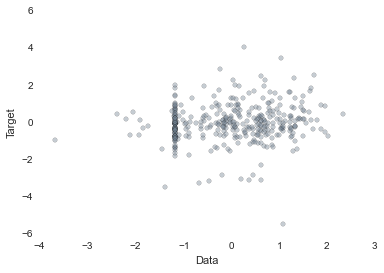

In [156]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

subX_train = X_train[:,0]
subX_test = X_test[:,0]
plt.scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
# plt.scatter(subX_test, y_test, c="seagreen", alpha=0.2, linewidths=0.3)
plt.xlabel('Data')
plt.ylabel('Target');

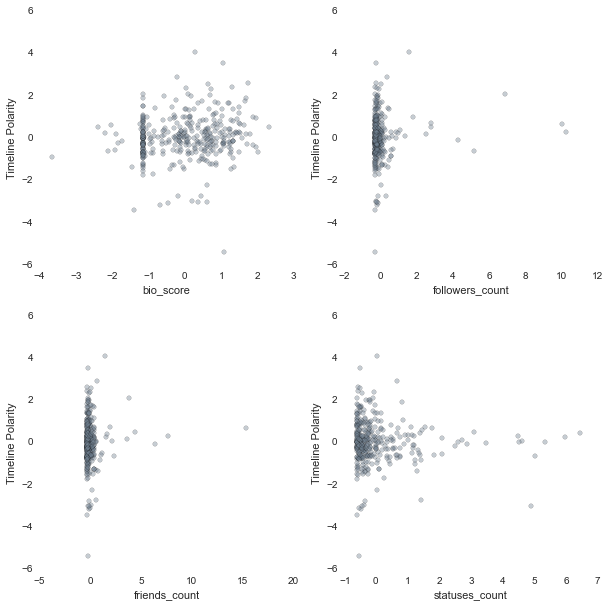

In [157]:
fig, axes = plt.subplots(2,2,figsize=(10,10))

for i in range(4):
    plt_i = i // 2
    plt_j = i % 2
    subX_train = X_train[:,i]
    # plt.subplot(2, 4, 1 + i)
    axes[plt_i][plt_j].scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
    #plt.scatter(subX_test, y_test)
    axes[plt_i][plt_j].set_xlabel(coll[i])
    axes[plt_i][plt_j].set_ylabel('Timeline Polarity'); 

In [158]:
#Creates a new linear regression object
regr = linear_model.LinearRegression(normalize=True)

In [159]:
#Fits the data
print X_train.shape
regr.fit(X_train, y_train);

(366, 4)


In [160]:
#Training and test error
print("Training error: ", metrics.mean_squared_error(regr.predict(X_train),y_train))
print("Test     error: ", metrics.mean_squared_error(regr.predict(X_test),y_test))

('Training error: ', 0.98671741249987788)
('Test     error: ', 1.0110645520988233)


In [161]:
#Training and test score
train_score = regr.score(X_train,y_train)
test_score = regr.score(X_test,y_test)
print("Training score: ", train_score)
print("Test     score: ", test_score)

('Training score: ', 0.04226003229174613)
('Test     score: ', -0.059397279239121747)


In [162]:
#Finds coefficients and intercept
coefficients = regr.coef_

for i in range(len(coefficients)):
    print coll[i],"\t",coefficients[i]
intercept = regr.intercept_

print intercept

bio_score 	0.148936418797
followers_count 	0.246392929193
friends_count 	-0.0940817478701
statuses_count 	-0.132668921458
0.014253321845


In [163]:
print pd.DataFrame(zip(coll, np.transpose(coefficients)))

                 0         1
0        bio_score  0.148936
1  followers_count  0.246393
2    friends_count -0.094082
3   statuses_count -0.132669


In [164]:
#Cross validation scores
regr = linear_model.LinearRegression()
scores = cross_validation.cross_val_score(regr, X, y, cv=5)
print scores

[-0.02140719 -0.01036419  0.01007307 -0.05209348  0.03807457]


In [165]:
#Regression score
print("Regression score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Regression score: -0.01 (+/- 0.06)


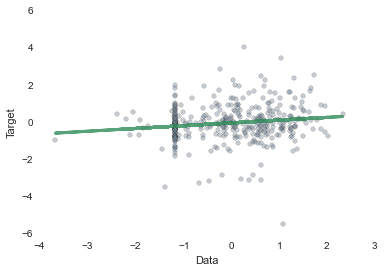

In [166]:
subX_train = X_train[:,0]
subX_test = X_test[:,0]
plt.scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
plt.plot(subX_train, ((coefficients[0]*subX_train)+intercept), color='seagreen', linewidth=3, alpha=.8);
plt.xlabel('Data')
plt.ylabel('Target');

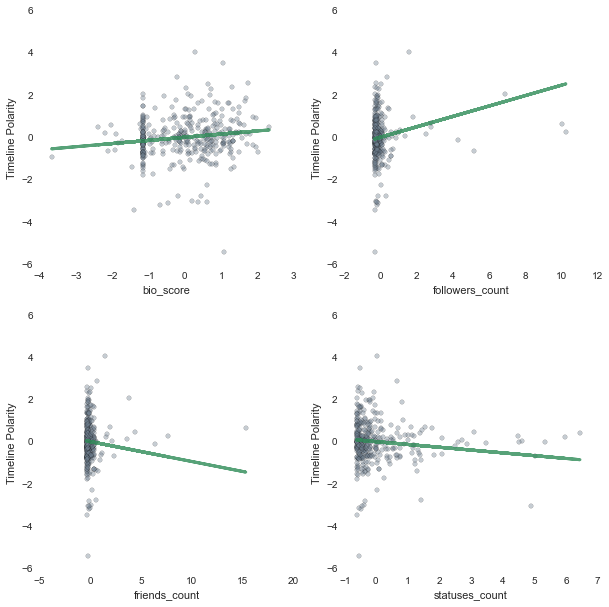

In [167]:
fig2, axes2 = plt.subplots(2,2,figsize=(10,10))

for i in range(4):
    plt_i = i // 2
    plt_j = i % 2
    subX_train = X_train[:,i]
    axes2[plt_i][plt_j].scatter(subX_train, y_train, c="slategray", alpha=0.4, linewidths=0.3)
    axes2[plt_i][plt_j].plot(subX_train, ((coefficients[i]*subX_train)+intercept), color='seagreen', linewidth=3, alpha=.8);
    axes2[plt_i][plt_j].set_xlabel(coll[i])
    axes2[plt_i][plt_j].set_ylabel('Timeline Polarity');

I wanted to measure timeline polarity as opposed to mentions polarity due to the fact that a throwaway account may not have many mentions.

* There appears to be a strong correlation between "followers count" and "niceness" of a user's timeline, which is somewhat expected. The more followers one has, the stronger their internet presense, thus it is highly likely they they are "nicer" on twitter.
* The feature with the second highest correaltion was "bioscore" which was the readability of a user's bio on twitter. Although there isn't a strong correlation, this was still expected as per my theory that mostly "throwaway" and "fake" accounts were used for tweeting "negatively". The higher the readability index the higher the timeline polarity.

### Logistic Regression with Detecting "Fake" Accounts

In [26]:
#Creates a copy of the dictionary with the bio and bioscores
all_users4 = all_users2.copy()

fake_combined1 = {}
fake_combined1.update(combined.gg_all)
fake_combined1.update(combined.sgg_all)
fake_combined1.update(combined.thanks_all)

all_usersDF = pd.DataFrame(all_users4).transpose()
fake_combinedDF = pd.DataFrame(fake_combined1).transpose()

#Adding bioscore to dataframe
fake_combinedDF['bio_score'] = all_usersDF['bio_score']

#Removes the outliers mentioned earlier
fake_combinedDF = fake_combinedDF.drop([242618658])
fake_combinedDF = fake_combinedDF.drop([91734908])

#Fills NaN with 0 
fake_combinedDF  = fake_combinedDF.fillna(0)

#Drops screen_name
fake_combinedDF = fake_combinedDF.drop(['screen_name'], axis=1)

fake_combinedDF

,favourites_count,followers_count,friends_count,listed_count,mentions_polarity,statuses_count,timeline_polarity,bio_score
20383,3068,400,679,17,0.056260,5325,0.107474,0.00
557563,70737,1071,997,74,0.077548,37117,0.058723,22.07
684743,4138,3738,3628,398,0.088005,42000,0.101288,45.42
1394361,3172,1536,1961,120,0.116536,46489,0.106894,20.04
1484341,3321,1033,1827,53,0.099180,37107,0.066226,44.41
5054001,398,3368,619,155,0.013869,18431,0.136552,44.41
8057892,1067,395,851,14,0.045203,18018,0.198918,44.41
11353012,28307,11903,11302,176,0.074496,31057,0.060580,6.17
12884962,6492,1085,961,86,0.111756,56805,0.072328,65.39
13796782,150,1450,774,75,0.164729,47191,0.114913,48.47


In [27]:
#Defines a throwaway as having mentions polarity < 0.05 and a bioscore < 29
fake_combinedDF['throwaway'] = ((fake_combinedDF.mentions_polarity < 0.05) &(fake_combinedDF.bio_score < 29)).astype(int)

fake_combinedDF

,favourites_count,followers_count,friends_count,listed_count,mentions_polarity,statuses_count,timeline_polarity,bio_score,throwaway
20383,3068,400,679,17,0.056260,5325,0.107474,0.00,0
557563,70737,1071,997,74,0.077548,37117,0.058723,22.07,0
684743,4138,3738,3628,398,0.088005,42000,0.101288,45.42,0
1394361,3172,1536,1961,120,0.116536,46489,0.106894,20.04,0
1484341,3321,1033,1827,53,0.099180,37107,0.066226,44.41,0
5054001,398,3368,619,155,0.013869,18431,0.136552,44.41,0
8057892,1067,395,851,14,0.045203,18018,0.198918,44.41,0
11353012,28307,11903,11302,176,0.074496,31057,0.060580,6.17,0
12884962,6492,1085,961,86,0.111756,56805,0.072328,65.39,0
13796782,150,1450,774,75,0.164729,47191,0.114913,48.47,0


In [28]:
newY = fake_combinedDF.throwaway

#Drops the negative_mentions column and mentions_polarity column
fake_combinedDF = fake_combinedDF.drop(['throwaway'], axis=1)
newX = fake_combinedDF

In [29]:
X2_train, X2_test, y2_train, y2_test = cross_validation.train_test_split(newX,
                                                                     newY,
                                                                     test_size=0.8,
                                                                     random_state=0
                                                                     )
logistic_regr = linear_model.LogisticRegression()
logistic_regr.fit(X2_train, y2_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [30]:
y2_predicted = logistic_regr.predict(X2_test)
print y2_predicted

[0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1
 0 1 0 0 0 0 0 0 1 1]


In [31]:
probs2 = logistic_regr.predict_proba(X2_test)
print probs2

[[  9.01760972e-01   9.82390282e-02]
 [  9.96400742e-01   3.59925751e-03]
 [  9.84573662e-01   1.54263376e-02]
 [  9.77356811e-01   2.26431890e-02]
 [  4.67393893e-01   5.32606107e-01]
 [  4.85199046e-01   5.14800954e-01]
 [  9.88002002e-01   1.19979978e-02]
 [  9.93307672e-01   6.69232755e-03]
 [  8.90409985e-01   1.09590015e-01]
 [  5.99999991e-01   4.00000009e-01]
 [  9.93479168e-01   6.52083181e-03]
 [  2.54152004e-03   9.97458480e-01]
 [  9.95018484e-01   4.98151569e-03]
 [  9.83730004e-01   1.62699956e-02]
 [  4.83201095e-01   5.16798905e-01]
 [  9.97355442e-01   2.64455837e-03]
 [  9.04025968e-01   9.59740321e-02]
 [  9.97120292e-01   2.87970771e-03]
 [  4.84385931e-01   5.15614069e-01]
 [  6.94231519e-01   3.05768481e-01]
 [  9.70504423e-01   2.94955767e-02]
 [  9.92350325e-01   7.64967474e-03]
 [  9.98740706e-01   1.25929444e-03]
 [  9.30242276e-01   6.97577238e-02]
 [  9.88018934e-01   1.19810662e-02]
 [  4.84833100e-01   5.15166900e-01]
 [  8.15287592e-01   1.84712408e-01]
 

In [32]:
print metrics.accuracy_score(y2_test, y2_predicted)

0.824847250509


In [33]:
print metrics.confusion_matrix(y2_test, y2_predicted)
print metrics.classification_report(y2_test, y2_predicted)

[[348  55]
 [ 31  57]]
             precision    recall  f1-score   support

          0       0.92      0.86      0.89       403
          1       0.51      0.65      0.57        88

avg / total       0.84      0.82      0.83       491



In [34]:
print pd.DataFrame(zip(newX.columns, np.transpose(logistic_regr.coef_)))

                   0                     1
0   favourites_count  [-5.65064165319e-07]
1    followers_count   [0.000680671918578]
2      friends_count  [-2.33191426359e-05]
3       listed_count    [-0.0143079163885]
4  mentions_polarity    [-0.0469392452088]
5     statuses_count  [-1.78443603011e-05]
6  timeline_polarity    [-0.0109915599974]
7          bio_score    [-0.0606958185998]


In [35]:
scores = cross_validation.cross_val_score(linear_model.LogisticRegression(),
                                          newX,
                                          newY,
                                          scoring='accuracy',
                                          cv=10)
print scores
print scores.mean()

[ 0.79032258  0.79032258  0.79032258  0.79032258  0.86885246  0.85245902
  0.75409836  0.85245902  0.81967213  0.86666667]
0.817549797285


Below, I use the model to predict if a user with the following stats is a throwaway account: 

* User 1:
    * Favourites count: 1250
    * Followers count: 3756
    * Friends count: 3345
    * Listed: 0
    * Mentions Polarity: 0.045
    * Statuses: 1245
    * Timeline polarity: -0.03
    * Bioscore: 20 

* User 2:
    * Favourites count: 3451
    * Followers found: 317
    * Friends count: 245
    * Listed: 3
    * Mentions polarity: 0.05
    * Statuses count: 4534
    * Timeline polarity: 0.07
    * Bioscore: 31


In [47]:
#Predictions for User 1
#Based on a random user I grabbed using #GamerGate when I explored the hashtag on the actual site
logistic_regr.predict_proba(np.array([1250,3756,3345,0,0.045,1245,-0.03,20]))

array([[ 0.21381709,  0.78618291]])

In [46]:
#Predictions for User 2
#Based on my own stats
logistic_regr.predict_proba(np.array([3451,317,245,3,0.05,4534,0.07,47]))

array([[ 0.93758205,  0.06241795]])

* Using bio score and mentions poalrity as features to predict if an account is a throwaway appears to give a relatively high accuracy with an accuracy of 81%
* However, given the confusion matrix, the model appears to have better accuracy in predicting if an account is NOT a "throwaway"
    * This is as expected as twitter still has difficult in detecting spam accounts. 

### Conclusions
* It appears that there is no strong correlation between "popularity" and how "mean" or negative a users' mentions are.
* The only seemingly correlated feature would be statuses count vs. mentions polarity where more statuses generally meant more positive tweets. I believe this is due to people making "throwaway" accounts to allow anonymity in negative tweets. I decided to investigate this further by detecting any fake accounts that might me "throwaways" or spam by measuring the readability index of their bios. 
* An interesting metric I wanted to evaluate was if there was a correlation between gender and negative mentions, however twitter's API does not return this information. 
* Overall, it appears that how "negative" people are to each other is arbitrary which is perhaps why twitter is currently having a hard time in dealing with predicting and dealing with harassment on their website as well as detecting any abusive accounts.  
    * When I explored this hypothesis I came to the following conclusions:
        * I suspected the #GamerGate tag to be the offending dataset (with the most "throwaway" accounts) 
        * There were 20 deleted accounts in the #GamerGate data set when I tried to explore thheir bios which supports the idea that users of this hashtag are using "throwaway" accounts.
        * Both #GamerGate and #StopGamerGate had the most "nonsense" bios. 
        * There is a small correlation between low readability index of their bios and the polarity in their time line. The more nonsensical their bio (aka. the more likely they are fake accounts), the more "negative" theri account's tweets are, which was as expected under the assumption that "throwaway" accounts are being used for harassment. 
    * Using bioscore and mentions polarity appear to be good predictors for detecting "throwaway" accounts with 81% accuracy. 


In [1]:
# Code for setting the style of the notebook, taken from 
from IPython.core.display import HTML
def css_styling():
    styles = open("./theme/custom.css", "r").read()
    return HTML(styles)
css_styling()